In [1]:
%load_ext autotime

# Examine Target

This notebook look at some of the properties for a specific target as pulled from the sources listed generated in the [Source Detection](PIAA-Source-Detection-And-Filtering.ipynb) notebook. 

Note that this step is not necessary for the processing of an observation sequence as a whole but instead serves to highlight some of the issues with processing the images in a traditional fashion and thus helps motivate our unique algorithm.

In [2]:
import os

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor
from piaa.utils import noise

from pocs.utils.images import fits as fits_utils
from pocs.utils.google.storage import PanStorage

from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy import units as u

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 4.05 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [8]:
# picid = 435715608
# picid = 287933433
# picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?
# picid = 11133916  # Same mag as HD189733
# picid = 86234511
# picid = helpers.get_star_info(twomass_id='20005694+2250490', cursor=tess_cursor).id
picid = 11135315

star_info = helpers.get_star_info(picid=picid, cursor=tess_cursor)

time: 91.6 ms


In [56]:
twomass = '20004370+2242391'

star_info = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor)
picid = star_info.id  # HD 189733

time: 49.2 ms


In [57]:
print(f'PICID: {picid}')

PICID: 256364928
time: 906 µs


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [4]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

sources = pipeline.lookup_sources_for_observation(filename=source_filename).set_index(['picid'], append=True)

time: 1.25 s


For our target table we want to compare the flux as calculated from `sextractor` (which has no knowledge of the RGB array) with that pulled from a custom stamp.  `sextractor` uses a 6-pixel circular aperture  centered around the calculated centroid (the `x` and `y` values in our `sources` table) while our custom stamps will use an aperture that is sliced according to our rule of having a fixed pixel pattern. Here we use a 6-pixel aperture on our stamps for direct comparison with `sextractor` but the size can be vary.

In [58]:
camera_bias = 2048 * u.adu
stamp_size = 6 * u.pixel
num_pixels = (stamp_size**2).value

readout_noise = 10.5 * u.electron / u.pixel
gain = 1.5 * (u.electron / u.adu)
qe = 0.43

focal_length = 85 * u.mm
fstop = 1.4

aperture_area = focal_length / fstop
aperture_area = (np.pi * (aperture_area / 2)**2).to(u.m * u.m)

time: 2.75 ms


In [59]:
num_sources = len(sources.index.levels[1])

time: 746 µs


In [61]:
est_style = dict(ls='-.')

# http://classic.sdss.org/dr5/algorithms/sdssUBVRITransform.html

filter_colors = {
    'B': 'b',
    'V': 'g',
    'R': 'r'
}

mags = {
    'R': 7.1, #star_info.gaiamag, # star_info.vmag - 0.46*(star_info.bmag - star_info.vmag) + 0.11,    
    'V': star_info.vmag,    
    'B': star_info.bmag,
}
mags

{'R': 7.1, 'V': 7.67, 'B': 8.607}

time: 4.24 ms


In [62]:
est_counts = list()

for pid, target_table in tqdm(sources.groupby('picid'), total=num_sources):
    for idx, row in target_table.iterrows():
        date_obs= idx[0]

        airmass = row.airmass
        exptime = row.exp_time

        scint_index = helpers.scintillation_index(exptime, airmass, 100, correction_coeff=1.5)                    
        
        for filter_name, mag in mags.items():
            photons = noise.estimated_photon_count(
                magnitude=mags[filter_name], 
                aperture_area=aperture_area, 
                filter_name=filter_name,
                airmass=airmass,
            ) * exptime

            # Apply RGGB pattern
            if filter_name == 'V':
                mult = 0.5
            else:
                mult = 0.25

            # Scale flux by number of pixels
            photons *= mult 

            # Get number of pixels for the filter
            n_pixels = int(num_pixels * mult)

            fill_factor = 0.5
            photons *= fill_factor

            transmission = 0.5
            photons *= transmission
            
            photons *= qe

            est_counts.append({
                'date_obs': date_obs,
                'picid': pid,
                'color': filter_colors[filter_name],
                'counts': int(photons / gain.value),
                'photon': int(photons),
                'photon_noise': 1/np.sqrt(photons),
                'readout_noise': (readout_noise * n_pixels).value / photons,
                'scint_noise': np.sqrt(scint_index)
            })


time: 3min 59s


In [63]:
est_counts = pd.DataFrame(est_counts).set_index(['date_obs'])
est_counts.to_csv(os.path.join(base_dir, f'estimated-noises.csv'))

time: 4.42 s


In [64]:
est_counts.head()

,color,counts,photon,photon_noise,picid,readout_noise,scint_noise
date_obs,,,,,,,
2018-08-22 04:02:02,r,25510,38266,0.005112,10777186,0.002470,0.006058
2018-08-22 04:02:02,g,23325,34988,0.005346,10777186,0.005402,0.006058
2018-08-22 04:02:02,b,7142,10713,0.009661,10777186,0.008820,0.006058
2018-08-22 04:07:23,r,25531,38297,0.005110,10777186,0.002468,0.005977
2018-08-22 04:07:23,g,23358,35037,0.005342,10777186,0.005394,0.005977


time: 15.5 ms


In [51]:
sources_noise = pd.read_csv(os.path.join(base_dir, f'point-sources-noise.csv')).set_index(['date_obs'])
sources_noise.index = pd.to_datetime(sources_noise.index)

time: 715 ms


In [65]:
target_table = sources_noise.loc[sources_noise.picid == picid]

time: 157 ms


In [66]:
bin_minutes = 15

time: 866 µs


In [67]:
binned_est = est_counts.groupby('color').resample(f'{bin_minutes}T').mean()
binned_target = target_table.resample(f'{bin_minutes}T').mean()

time: 239 ms


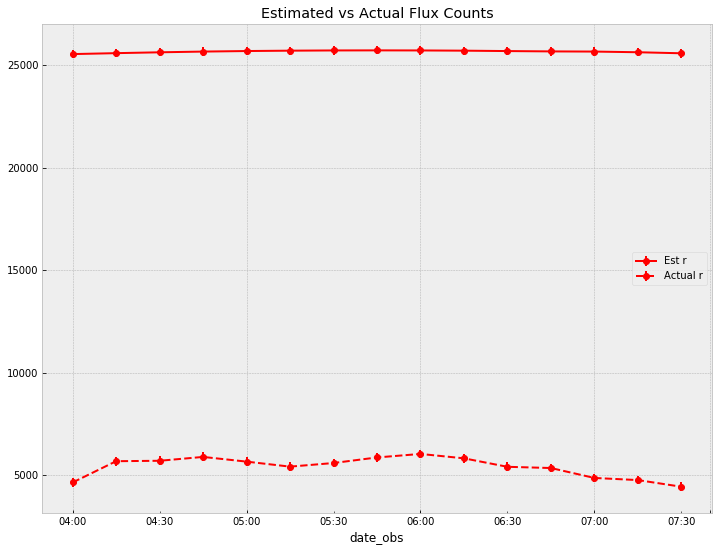

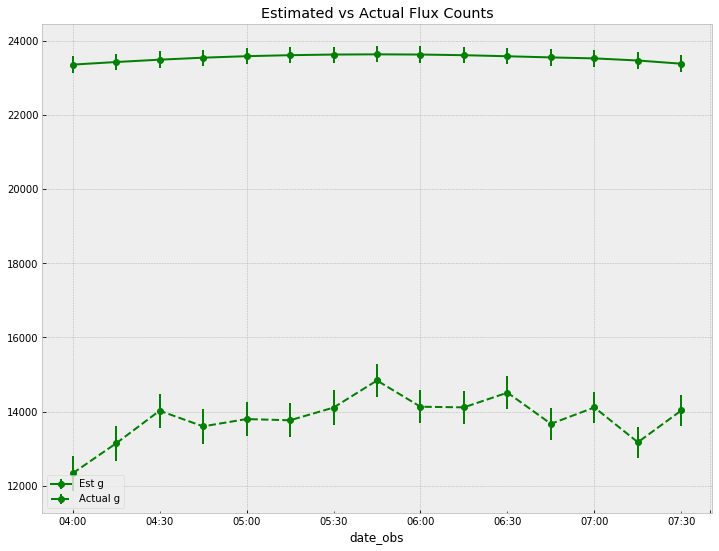

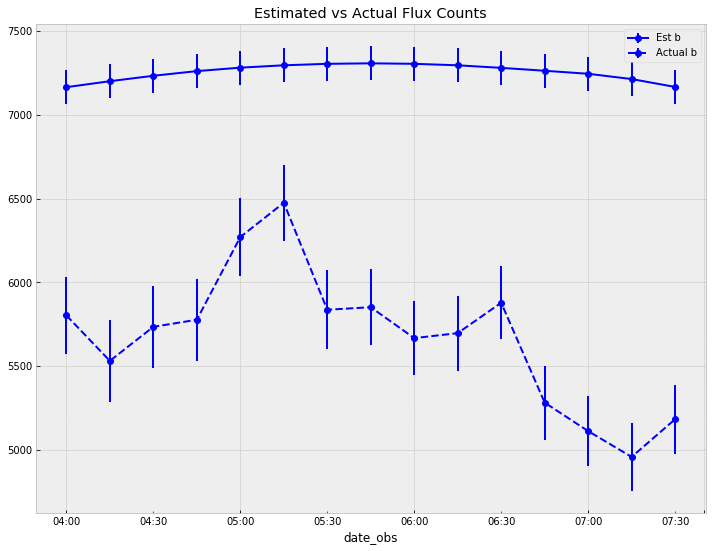

time: 1.85 s


In [73]:
for color in 'rgb':    
    plt.figure(figsize=(12, 9))
    color_data = binned_est.loc[color]
    
    est_noise = np.sqrt(color_data.photon_noise**2 + color_data.readout_noise**2 + color_data.scint_noise**2)
    target_noise = np.sqrt(binned_target[f'{color}_back_std']**2 + binned_target[f'{color}_readout_noise']**2 + binned_target[f'{color}_stamp_noise']**2)

    color_data.counts.plot(marker='o', color=color, yerr=(color_data.counts * est_noise), label=f'Est {color}')
    binned_target[f'{color}_stamp'].plot(yerr=target_noise, color=color, marker='o', ls='--', label=f'Actual {color}')
        
    plt.title('Estimated vs Actual Flux Counts')
    plt.legend()